In [27]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import pandas_datareader as web
import seaborn as sns

In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style("white")
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# 1. Get dataset from api website

In [29]:
"""Get the data from pandas datareader"""
def get_fred_dataset(symbol, date_time):
    """
    input: symbol - the symbol of the dataset
              date_time - the date to start the dataset
    output: xs - the date time values
                ys - the numeric values of the dataset
    """
    symbol = symbol 
    reader = web.fred.FredReader(symbol, start=pd.to_datetime(date_time))
    dataset = reader.read()
    #get numeric values from the pandas dataframe
    xs = dataset.index
    ys = dataset[symbol]
    return xs,ys

## Overview of dataset
[Fred](https://fred.stlouisfed.org/), short for Federal Reserve Economic Data, FRED is an online database consisting of hundreds of thousands of economic data time series from scores of national, international, public, and private sources.

In this problem, we will use 4 datasets: 

*   BRENT crude oil price: (DCOILBRENTEU) 
*   Heating Oil Prices: New York Harbor (DHOILNYH)
*   CBOE Crude Oil ETF Volatility Index (OVXCLS)
*   Conventional Gasoline Prices: New York Harbor, Regular (DGASNYH) 

In [30]:
# Get the DCOILBRENTEU dataset with data starting from 1-1-1880
xs,ys = get_fred_dataset('DCOILBRENTEU', '1880-01-01')

In [31]:
# Visualize the dataset with matplotlib for time series
def plot_time_series(symbol, date_time):
    """
    input: symbol - the symbol of the dataset
              date_time - the date to start the dataset
    output: None
    """
    xs,ys = get_fred_dataset(symbol, date_time)
    plt.plot(xs, ys)
    plt.title(f"{symbol} dataset from {date_time}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.show()

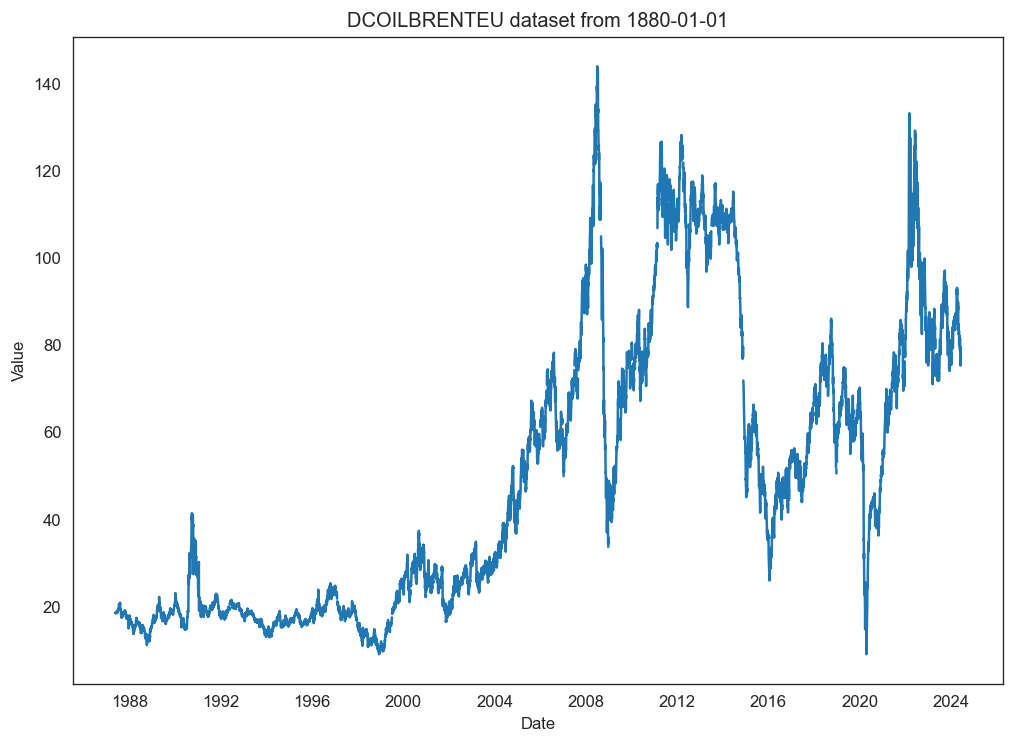

In [32]:
# Visualize the DCOILBRENTEU dataset
plot_time_series('DCOILBRENTEU', '1880-01-01')

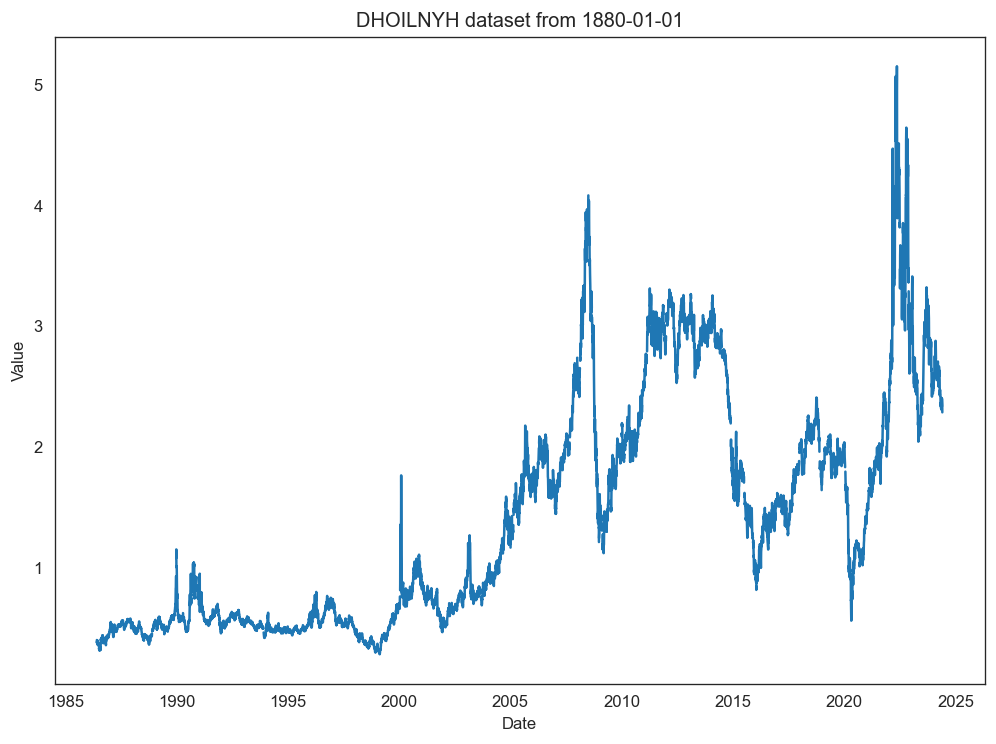

In [33]:
# Visualize the DHOILNYH dataset
plot_time_series('DHOILNYH', '1880-01-01')

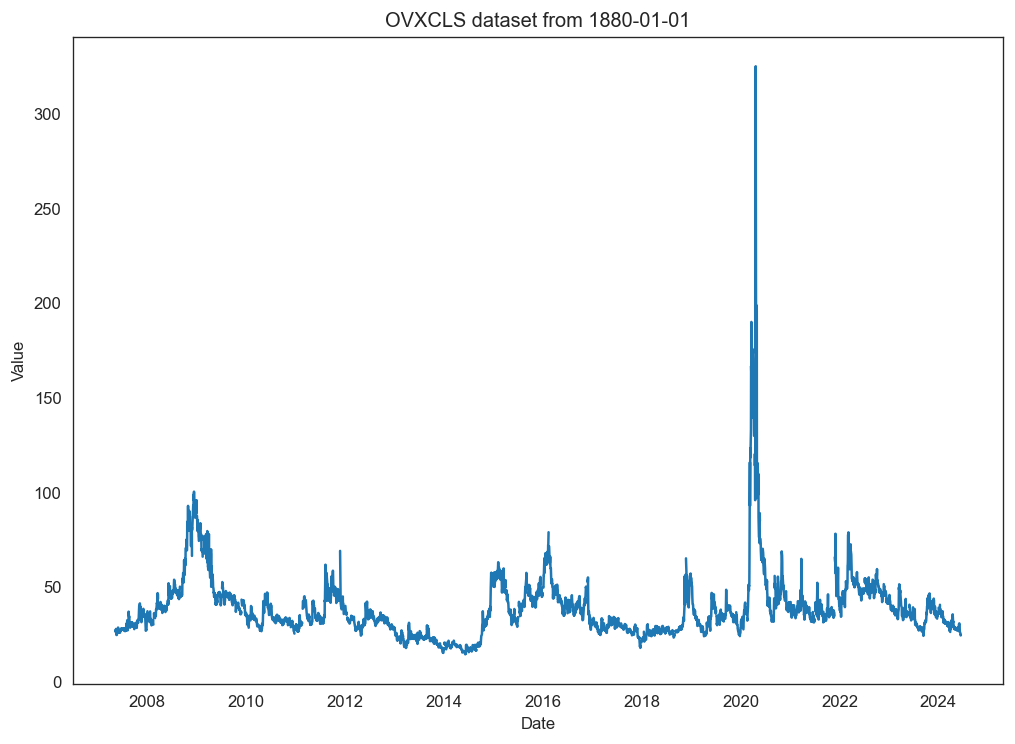

In [34]:
# Visualize the OVXCLS dataset
plot_time_series('OVXCLS', '1880-01-01')

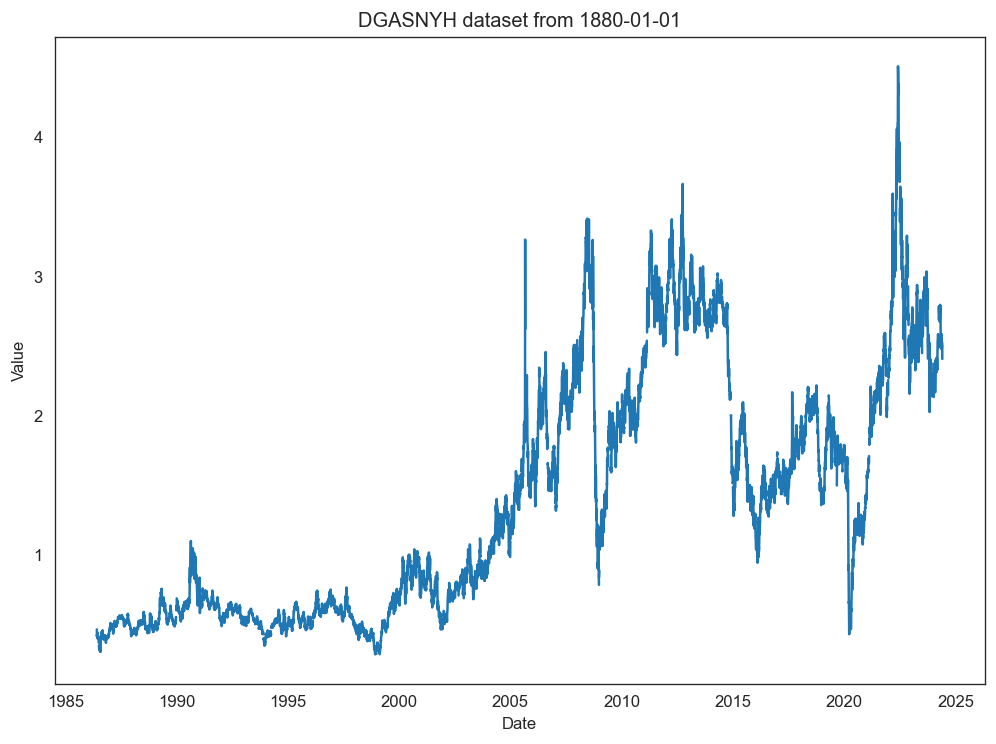

In [35]:
# Visualize the DGASNYH dataset
plot_time_series('DGASNYH', '1880-01-01')

# 2. Pre processing data

In [43]:
# Calcilate the linear inpute for the missing value between two points
import numpy as np


def linear_impute(y_start, y_end, npoints):
    """
    Input: y_start - the start value
               y_end - the end value
               npoints - the number of points to generate
    Output: the imputed values"""
    m = (y_end - y_start) / (npoints)
    c = y_start
    values = [m*x + c for x in range(1, npoints)]
    return values

# Linear impute the missing values in the dataset
def basic_imputation(ys):
    ys_imputed = np.copy(ys)
    b = np.isnan(ys_imputed)
    nan_positions = np.argwhere(b)
    segments = []
    for i in range(nan_positions.shape[0]):
        start = nan_positions[i]
        end = start
        while np.isnan(ys_imputed[end]) and end < ys.shape[0]:
            end = end + 1
        segments.append((start,end))
    for (start,end) in segments:
        y_start = ys_imputed[start-1]
        y_end = ys_imputed[end]
        linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
        # Ensure linear is a 1-dimensional array
        linear = np.array(linear).flatten()

        # Ensure the slice of ys_imputed matches the shape of linear
        assert len(ys_imputed[int(start):int(end)]) == len(linear)

        ys_imputed[int(start):int(end)] = linear
    return ys_imputed

In [46]:
# Visualize the DCOILBRENTEU dataset with the imputed values
def plot_imputed_time_series(symbol, date_time):
    """
    input: symbol - the symbol of the dataset
              date_time - the date to start the dataset
    output: None
    """
    xs,ys = get_fred_dataset(symbol, date_time)
    ys_imputed = basic_imputation(ys)
    plt.plot(xs, ys_imputed)
    plt.title(f"{symbol} dataset from {date_time}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.show()

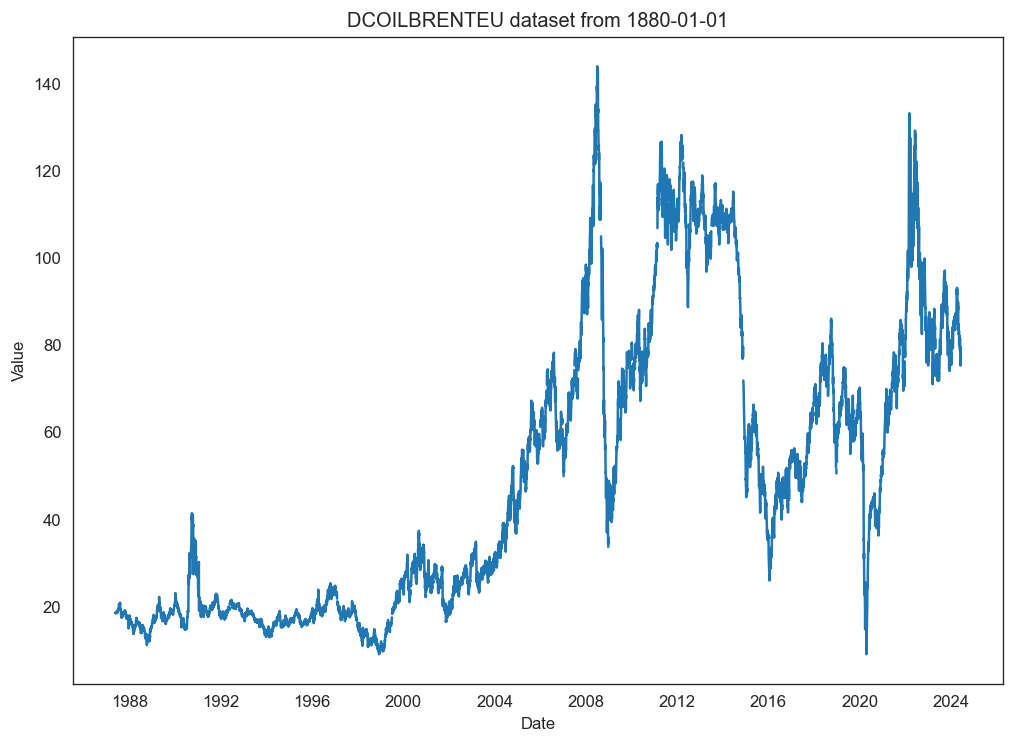

In [48]:
plot_time_series('DCOILBRENTEU', '1880-01-01')

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_88245/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_88245/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_88245/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

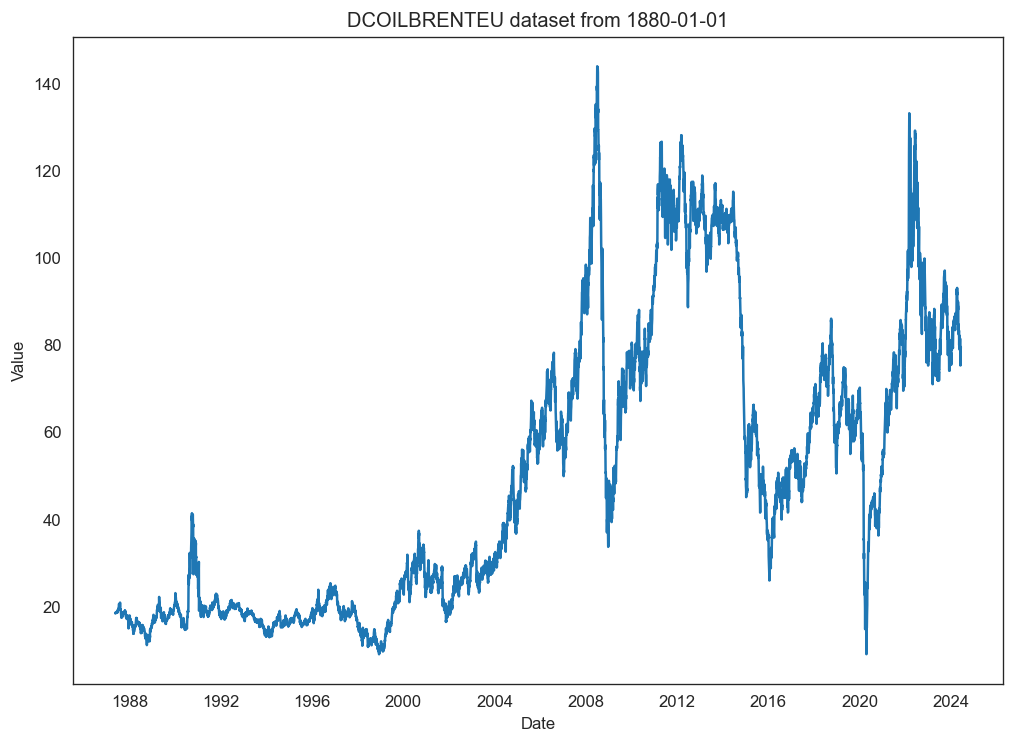

In [47]:
plot_imputed_time_series('DCOILBRENTEU', '1880-01-01')

## Seasonal and Trend Decomposition based Lo

In [50]:
def get_residual_com(symbol, y,index):
    y_df = pd.DataFrame({symbol: y}, index=index)
    y_decom = seasonal_decompose(y_df, model='multiplicative')
    y_res= np.copy(y_decom.resid) 
    #padding missing "nan" datapoints with 1 at the beginning and end of residual sequence y_res
    y_res[0:2]=1
    y_res[y_res.shape[0]-2:y_res.shape[0]]=1
    return y_res

In [51]:
def plot_residuals(symbol, date_time):
    """
    input: symbol - the symbol of the dataset
              date_time - the date to start the dataset
    output: None
    """
    xs,ys = get_fred_dataset(symbol, date_time)
    ys_imputed = basic_imputation(ys)
    y_res = get_residual_com(symbol,ys_imputed,xs)
    plt.plot(xs, y_res)
    plt.title(f"{symbol} dataset from {date_time}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.show()

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_88245/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_88245/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_88245/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

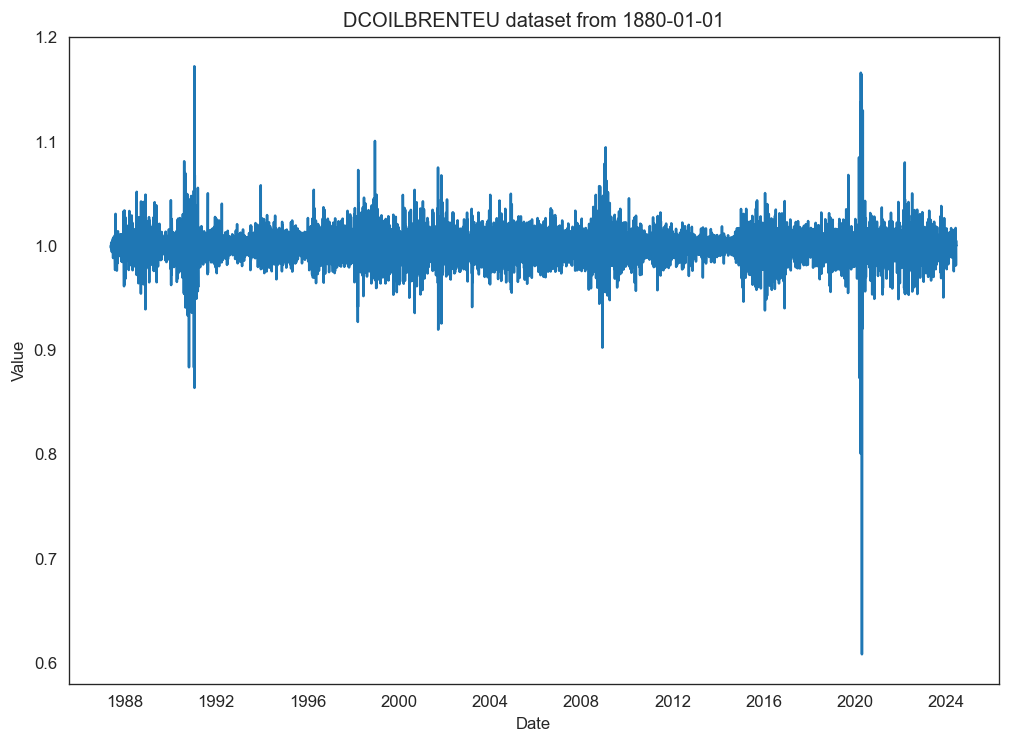

In [52]:
plot_residuals('DCOILBRENTEU', '1880-01-01')